In [1]:
import torch
import os
from pathlib import Path
import matplotlib.pyplot as plt

from mrnet.training.trainer import MRTrainer
from mrnet.datasets.signals import ImageSignal
from mrnet.networks.mrnet import MRFactory
from mrnet.datasets.pyramids import create_MR_structure
from mrnet.datasets.sampler import make_grid_coords
from mrnet.training.listener import TrainingListener

from utils import load_hyperparameters, get_optim_handler

In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = "train-eval.ipynb"
BASE_DIR = Path('.').absolute().parents[0].parents[0]
MODEL_PATH = BASE_DIR.joinpath('runs/models')

In [3]:
config_file = '../configs/image.yml'
hyper = load_hyperparameters(config_file)
project_name = hyper.get('project_name', "framework-tests")
# example: overriding config in code; 
# comment the next line if you want to keep local logging
hyper['logger'] = 'wandb'

In [4]:
base_signal = ImageSignal.init_fromfile(
                        os.path.join(BASE_DIR, hyper['data_path']),
                        domain=hyper['domain'],
                        channels=hyper['channels'],
                        sampling_scheme=hyper['sampling_scheme'],
                        width=hyper['width'], height=hyper['height'],
                        attributes=hyper['attributes'],
                        batch_size=hyper['batch_size'],
                        color_space=hyper['color_space'])
train_dataset = create_MR_structure(base_signal,
                                        hyper['max_stages'],
                                        hyper['filter'],
                                        hyper['decimation'],
                                        hyper['pmode'])
test_dataset = create_MR_structure(base_signal,
                                    hyper['max_stages'],
                                    hyper['filter'],
                                    False,
                                    hyper['pmode'])

# you can substitute this line by your custom handler class
optim_handler = get_optim_handler(hyper.get('optim_handler', 'regular'))

In [5]:
mrmodel = MRFactory.from_dict(hyper)
print("Model: ", type(mrmodel))
name = os.path.basename(hyper['data_path'])
logger = TrainingListener(project_name,
                            f"{hyper['model']}{hyper['filter'][0].upper()}{name[0:7]}{hyper['color_space'][0]}",
                            hyper,
                            Path(hyper.get("log_path", "runs")))
mrtrainer = MRTrainer.init_from_dict(mrmodel,
                                    train_dataset,
                                    test_dataset,
                                    logger,
                                    hyper,
                                    optim_handler=optim_handler)
mrtrainer.train(hyper['device'])

Model:  <class 'mrnet.networks.mrnet.MNet'>


wandb: Currently logged in as: hallpaz (siren-song). Use `wandb login --relogin` to force relogin


DATA SIZE torch.Size([3, 64, 64])
torch.Size([64, 64, 3]) DEBUG 1
[Logger] All inference done in 3.2397148609161377s on cuda
Total model parameters =  8898


D0 loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
D1 loss,█▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
D0 loss,0.0012
D1 loss,3.58755
Total loss,0.0012


DATA SIZE torch.Size([3, 128, 128])
torch.Size([128, 128, 3]) DEBUG 1
[Logger] All inference done in 2.9151625633239746s on cuda
Total model parameters =  59204


D0 loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
D1 loss,▁▁▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████████████████
Total loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
D0 loss,0.00046
D1 loss,61.62698
Total loss,0.00046


DATA SIZE torch.Size([3, 256, 256])
torch.Size([256, 256, 3]) DEBUG 1
[Logger] All inference done in 3.264106512069702s on cuda
Total model parameters =  159110


D0 loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
D1 loss,▁▂▂▃▄▅▆▆▇▇▇▇▇▇▇█████████████████████████
Total loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
D0 loss,0.0002
D1 loss,185.84317
Total loss,0.0002


Training finished after 3000 epochs


In [6]:
basename = os.path.basename(hyper['data_path']).split('.')[0]
filename = f"{hyper['model']}{hyper['filter'][0].upper()}{basename[0:7]}.pth"
path = os.path.join(MODEL_PATH, filename)
os.makedirs(MODEL_PATH, exist_ok=True)
MRFactory.save(mrmodel, path)
print('Model saved to: ', path)

Model saved to:  e:\Workspace\impa\mrnet\runs\models\MGtwo_mac.pth


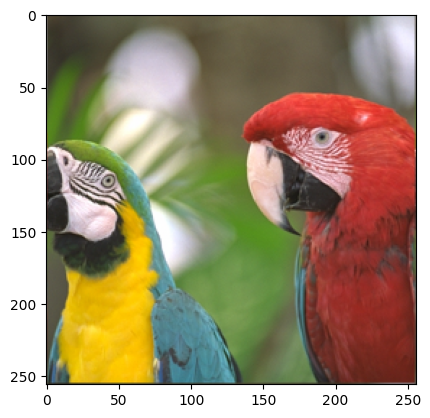

In [7]:
mrmodel_eval = MRFactory.load_state_dict(path)

output = mrmodel_eval(make_grid_coords((hyper['width'], hyper['height']), 
                                       *hyper['domain'], dim=2))
model_out = torch.clamp(output['model_out'], 0.0, 1.0)

plt.imshow(model_out.cpu().view(hyper['width'], hyper['height'], hyper['channels']).detach().numpy())